In [ ]:
!pip install brian2

In [ ]:
import matplotlib.pyplot as plt
from brian2 import *
from IPython.display import clear_output
import numpy as np
import random
import pandas as pd
import matplotlib
from pathlib import Path
from PIL import Image
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
# from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

Стандартная модель STDP:
\begin{equation}
\nonumber
  \Delta w(\Delta t) = \begin{cases}
  	A_{pre} e^{-\Delta t/\tau_{pre}},\;\;\; \Delta t > 0\\
  	A_{post} e^{\Delta t/\tau_{post}},\;\;\; \Delta t < 0
  \end{cases}.
\end{equation}
Метод «следов», предложенный в документации к библиотеке brian2:
\begin{equation}
\tau_{pre}\frac{d}{dt}a_{pre} = -a_{pre}\\
\tau_{post}\frac{d}{dt}a_{post} = -a_{post}
\end{equation}
При пре-спайке:
\begin{equation}
a_{pre} \rightarrow a_{pre} + A_{pre}\\
w \rightarrow w + a_{post}
\end{equation}
При пост-спайке:
\begin{equation}
a_{post} \rightarrow a_{post} + A_{post}\\
w \rightarrow w + a_{pre}
\end{equation}
Докажем идентичность этих методов, построив графики зависимости изменения веса от задержки между спайками.

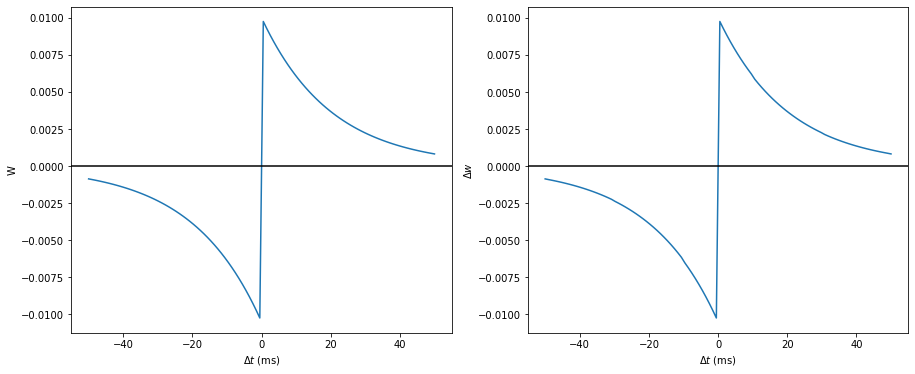

In [ ]:
plt.figure(figsize=(15, 6))
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre*1.05
delta_t = linspace(-50, 50, 100)*ms
W = where(delta_t>0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
plt.subplot(121)
plot(delta_t/ms, W)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k')

start_scope()
taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms) 
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms) 
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'
S = Synapses(G, H, '''
                    w:1
                    dapre/dt = -apre/taupre : 1 (event-driven) dapost/dt = -apost/taupost : 1 (event-driven) ''',
                    on_pre='''
                    apre += Apre
                    w = w+apost
                    ''',
                    on_post='''
                    apost += Apost
                    w = w+apre
                    ''')
S.connect(j='i')
run(tmax+1*ms)
plt.subplot(122)
plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');

[[0.02206562 0.08864613 0.02096567 0.00653372 0.06301078]
 [0.01876065 0.07588024 0.03298653 0.01729667 0.04537549]
 [0.94050321 0.95902855 0.99916651 0.96603309 0.91813572]
 [0.01901164 0.08102043 0.05011841 0.01769846 0.06586413]
 [0.09290982 0.07019938 0.07162418 0.09030674 0.07800063]]


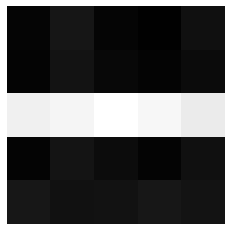

In [ ]:
def get_pattern(pattern='-', noise=0):
    """
    pattern: '-' или '|' или '/' - тип узора
    noise: от 0 до 1 - уровень шума
    Функция возвращает массив размером (9,) с интенсивностями пикселей.
    """
    if pattern == '-':
        image = np.array([0, 0, 0, 0, 0,
                          0, 0, 0, 0, 0,
                          1, 1, 1, 1, 1,
                          0, 0, 0, 0, 0,
                          0, 0, 0, 0, 0])
    elif pattern == '|':
        image = np.array([0, 0, 1, 0, 0,
                          0, 0, 1, 0, 0,
                          0, 0, 1, 0, 0,
                          0, 0, 1, 0, 0,
                          0, 0, 1, 0, 0])
    elif pattern == '/':
        image = np.array([0, 0, 0, 0, 1,
                          0, 0, 0, 1, 0,
                          0, 0, 1, 0, 0,
                          0, 1, 0, 0, 0,
                          1, 0, 0, 0, 0])
    if noise:
      image = np.ones(25) - np.fabs(np.random.rand(25)*noise + image - np.ones(25))
    # return image.reshape(-1)
    return image


seed()
plt.axis('off')
image = get_pattern(pattern='-', noise=0.1).reshape(5, 5)
print(image)
plt.imshow(image, cmap='gray', vmin=0, vmax=1)

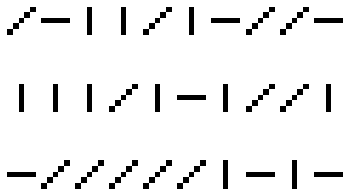

In [ ]:
#примеры изображений
fig = plt.figure()
image_number = 30
cols = 10
rows = image_number // cols + image_number % cols
position = range(1, image_number + 1)
i = 0
for pattern in random.choices(['-', '|', '/'], k=image_number):
    clear_output(wait=True)
    ax = fig.add_subplot(rows, cols, position[i])
    ax.axis('off')
    plt.imshow(np.ones((5, 5))-get_pattern(pattern=pattern, noise=False).reshape(5, 5), cmap='gray')
    i += 1

In [ ]:
def input_layer(image, sample_rate, t0, dt):
  """
    image - массив (25,) с интенсивностью пикселей
    sample rate - частота дискретизации интенсивности зашумленного пикселя
    t - начальное время подачи изображения
    dt - разница между спайками на один пиксель

    Функция создает два массива с номерами спайкующих нейронов и времени их зажигания

    indeces - массив с номерами зажигающихся нейронов
    times - массив с временами зажигающихся нейронов
  """
  image = image.reshape(-1)
  output_neurons = np.zeros(image.shape)
  if (sample_rate == 1):
    indeces = np.where(image > 0)[0]
    times = np.array([t0] * len(indeces))
  else:
    for i in range(sample_rate - 1):
      output_neurons += (image >= (i + 1) * (np.ones(image.shape) / sample_rate))
      indeces, times = np.array([]), np.array([])
      output_neurons = output_neurons.astype(int)
    for i in range(len(output_neurons)):
      indeces = np.append(indeces, [i] * output_neurons[i])
      times = np.append(times, [t0 + j*dt for j in range(output_neurons[i])])
  return indeces, times

In [ ]:
def visualise_connectivity(S):
  """
    S - объект синапсов brian2
    Функция визуализирует синапсы. Толщина пропорциональна весу.
    Красные связи соответствуют положительным весам, синие - отрицательным.
  """

  Ns = len(S.source)
  Nt = len(S.target)
  figure(figsize=(5, 4))
  plot(zeros(Ns), arange(Ns), 'ok', ms=10) 
  plot(ones(Nt), 1 + arange(Nt), 'ok', ms=10) 
  for i, j in zip(S.i, S.j):
    if S.w[i, j] >= 0:
      plot([0, 1], [i, j+1], '-k', linewidth=S.w[i, j]/max(S.w[:]), c='red')
    else:
      plot([0, 1], [i, j+1], '-k', linewidth=S.w[i, j]/max(S.w[:]), c='blue')
  xticks([0, 1], ['Input', 'Output'])
  ylabel('Neuron index')
  xlim(-0.1, 1.1)
  ylim(-1, max(Ns, Nt))
  

WARNING    't' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 7500. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


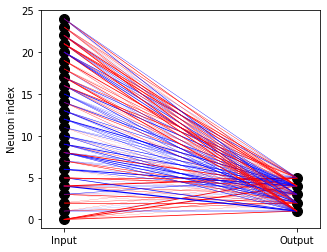

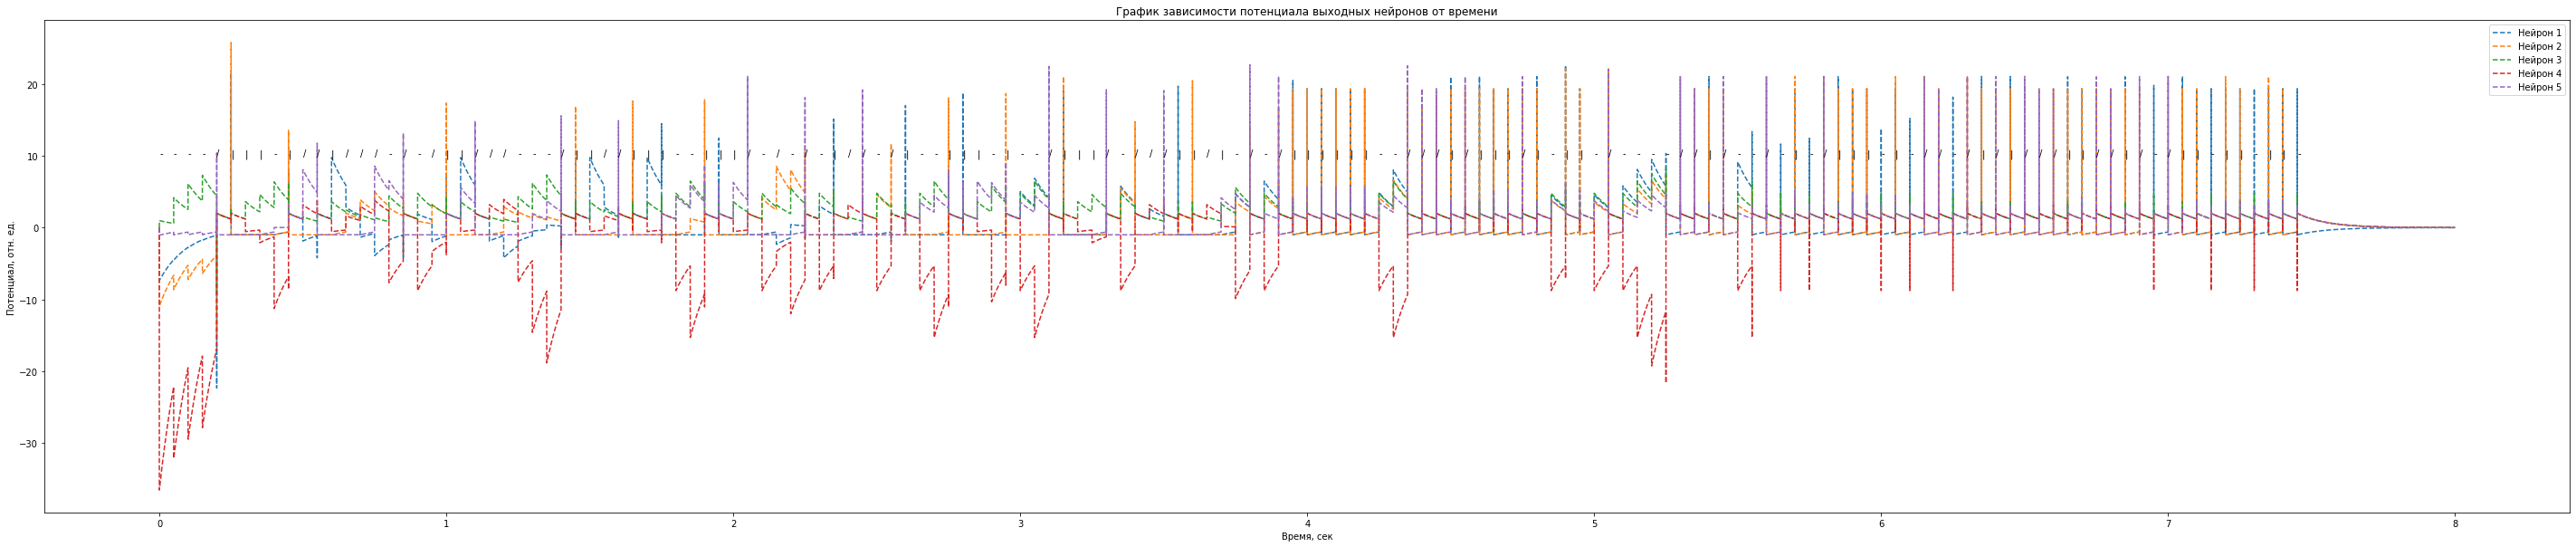

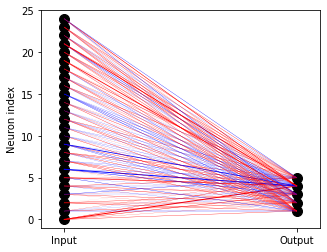

In [ ]:
start_scope()
seed(0)

image_number = 150                       # число изображений для тренировки
t = 0                                   # начало показа изображений
delta_t = 50                            # задержка между изображениями
n_in = 25                               # число входных нейронов
n_out = 5                               # число выходных нейронов
taupre = 20 * ms                       # характерное время пре-следа
taupost = taupre * 1.7                  # характерное время пост-следа
w_max = 4                               # максимальное значение веса
Apre = 0.8                              # коэффициент пре-следа
Apost = -Apre * 0.6                    # коэффициент пост-следа
v_treshold = 10                         # пороговое напряжение зажигания
v_reset = -1                            # напряжение сброса
v_inh = 2                               # напряжение торможения
tau_synapses = 100 * ms                 # характерное время релаксации нейрона
I_neuron = 0                            # ток через нейрон
w0 = np.random.normal(-0.5, 6, n_in*n_out) # начальные веса

# Задаем начальные условия
indeces, times = np.array([]), np.array([])
patterns = random.choices(['-', '|', '/'], k=image_number)
for pattern in patterns:
  image = get_pattern(pattern=pattern, noise=0)
  i_, t_ = input_layer(image=image, sample_rate=1, t0=t, dt=0)
  indeces = np.append(indeces, i_)
  times = np.append(times, t_)
  t+=delta_t
indeces, times = list(indeces.reshape(-1)), list(times.reshape(-1))

# Уравнения, описывающие сеть
eq_neuron = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
I:1
tau : second
'''

eq_synapse = '''
w:1
dapre/dt = -apre/taupre : 1 (clock-driven)
dapost/dt = -apost/taupost : 1 (clock-driven)
'''

# Задаем генератор спайков
spike_generator = SpikeGeneratorGroup(n_in, indices=indeces,
                        times=times * ms)

# Задаем выходные нейроны
output_neurons = NeuronGroup(n_out, eq_neuron,
                threshold='v>v_treshold',
                reset='v = v_reset',
                method='euler',
                refractory = '3*delta_t*(t < delta_t * image_number / 2* ms)* ms')
output_neurons.I = I_neuron
output_neurons.tau = tau_synapses

# Задаем синапсы между ними
synapses = Synapses(spike_generator, output_neurons, eq_synapse,
              on_pre='''
              v_post += w
              apre += Apre
              w = clip(w+apost, -0.5*w_max, w_max)
              ''',
              on_post='''
              apost += Apost
              w = clip(w+apre, -w_max, w_max)
              ''',
              method='euler')
synapses.connect()
synapses.w = w0
synapses.apre = synapses.apost = np.zeros(n_in * n_out)
visualise_connectivity(synapses)

# Задаем тормозящие связи
synapses_inh = Synapses(output_neurons, output_neurons, 
              on_pre='''
              v_post = v_inh
              ''')
synapses_inh.connect(condition='i!=j')

# Записываем динамику сети
monitor = StateMonitor(output_neurons, 'v', record=True)
weights_monitor = StateMonitor(synapses, 'w', record=True)

# Запускаем моделирование
run((delta_t/1000 * image_number + 0.5)* second)

# Рисуем
figure(figsize=(50, 10))
plt.title('График зависимости потенциала выходных нейронов от времени')
for k in range(n_out):
    plot(monitor.t / second, monitor.v[k], label='Нейрон ' + str(k + 1), linestyle = '--')
for i in range(image_number):
  plt.text(delta_t/1000 * i, v_treshold, patterns[i])
xlabel('Время, сек')
ylabel('Потенциал, отн. ед.')
legend()
plt.show()

visualise_connectivity(synapses)

Text(0, 0.5, 'Input')

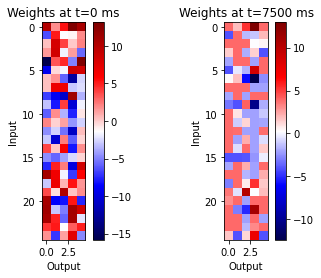

In [ ]:
plt.figure(figsize=(6, 4))
plt.subplot(121)
imshow(weights_monitor.w[:, 0].reshape(n_in, n_out), cmap='seismic')
title(f'Weights at t={0} ms')
colorbar()
xlabel('Output')
ylabel('Input')
plt.subplot(122)
imshow(weights_monitor.w[:, -1].reshape(n_in, n_out), cmap='seismic')
title(f'Weights at t={t} ms')
colorbar()
xlabel('Output')
ylabel('Input')

In [ ]:
frames = []
# print(WM.w[:, 40000])
for t in range(0, 7000, 100):
  plt.figure(figsize=(3,3))
  plt.imshow(weights_monitor.w[:, t].reshape(25, 5), cmap='seismic')
  plt.title(f'Weights at t={t} ms')
  plt.colorbar()
  plt.xlabel('Output')
  plt.ylabel('Input')
  plt.savefig(f'plot_{t}.png', dpi=90)
  plt.close()

for t in range(0, 7000, 100):
  frame = Image.open(f'plot_{t}.png')
  frames.append(frame)

frames[0].save(
        'weights_dynamic.gif',
        save_all=True,
        append_images=frames[1:],
        optimize=True,
        duration=[100] * len(frames),
        loop=0
        )
from google.colab import files
files.download('weights_dynamic.gif') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    'i' is an internal variable of group 'synapses_7', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


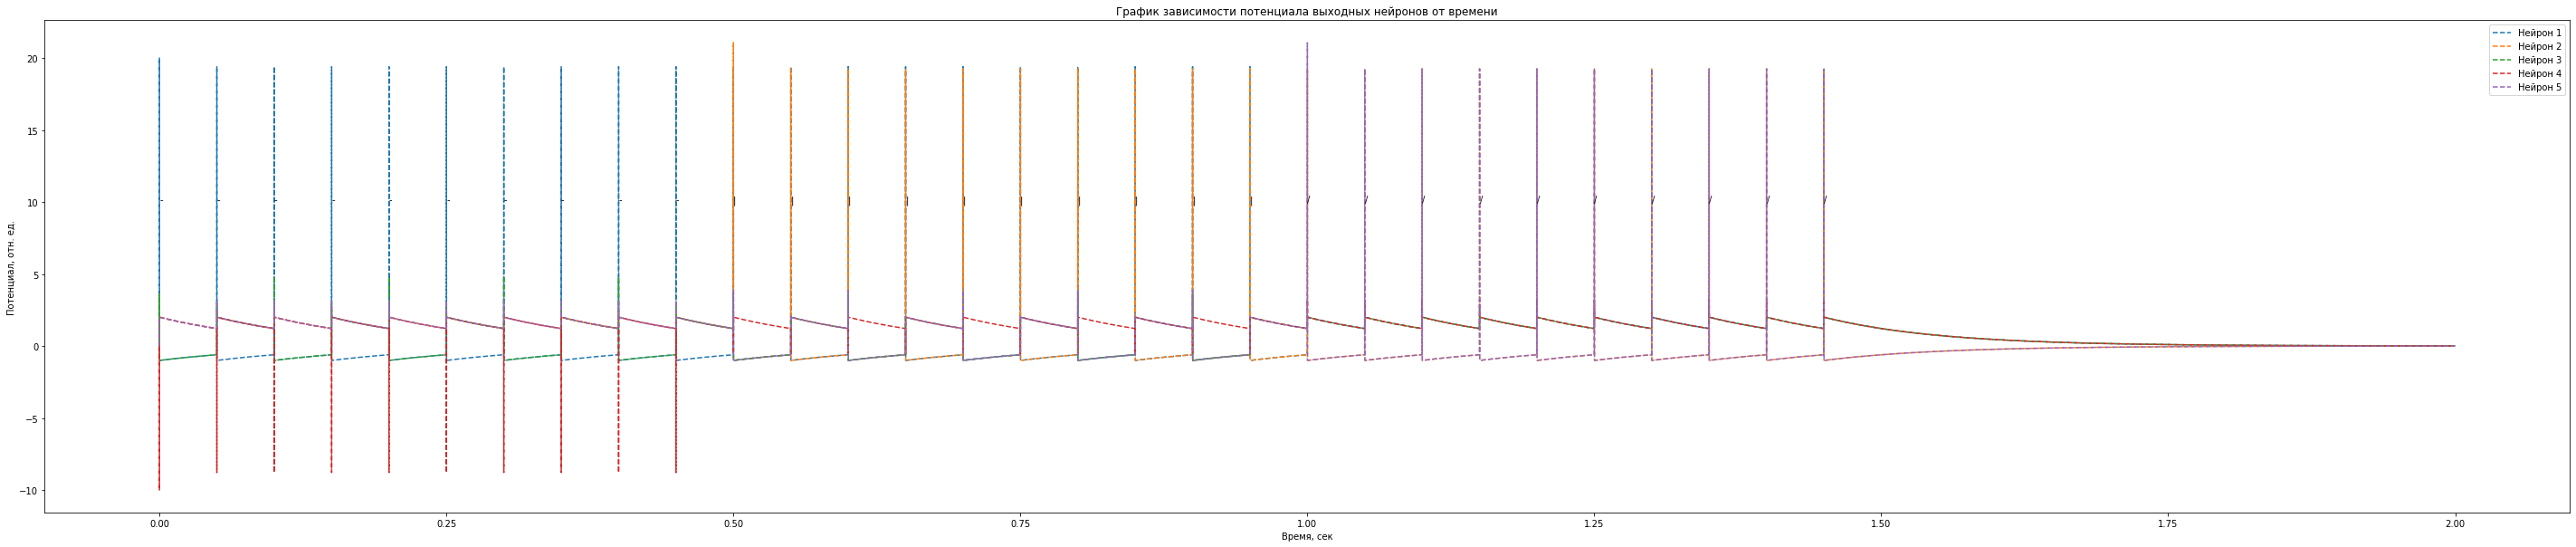

In [ ]:
start_scope()
seed(0)

image_number = 30                       # число изображений для тренировки

# Задаем начальные условия
indeces, times = np.array([]), np.array([])
# patterns = random.choices(['-', '|', '/'], k=image_number)
patterns = ['-']*int(image_number/3) + ['|']*int(image_number/3) + ['/']*int(image_number/3)
t = 0
for pattern in patterns:
  image = get_pattern(pattern=pattern, noise=0)
  i_, t_ = input_layer(image=image, sample_rate=1, t0=t, dt=0)
  indeces = np.append(indeces, i_)
  times = np.append(times, t_)
  t+=delta_t
indeces, times = list(indeces.reshape(-1)), list(times.reshape(-1))

# Задаем генератор спайков
spike_generator_2 = SpikeGeneratorGroup(n_in, indices=indeces,
                        times=times * ms)

# Задаем выходные нейроны
output_neurons_2 = NeuronGroup(n_out, eq_neuron,
                threshold='v>v_treshold/3',
                reset='v = v_reset',
                method='euler')
output_neurons_2.I = I_neuron
output_neurons_2.tau = tau_synapses

# Задаем синапсы между ними
synapses_2 = Synapses(spike_generator_2, output_neurons_2, eq_synapse,
              on_pre='''
              v_post += w
              ''',
              method='euler')
synapses_2.connect()
synapses_2.w = synapses.w[:]
synapses_2.apre = synapses_2.apost = np.zeros(n_in * n_out)

# Задаем тормозящие связи
synapses_2_inh = Synapses(output_neurons_2, output_neurons_2, 
              on_pre='''
              v_post = v_inh
              ''')
synapses_2_inh.connect(condition='i!=j')

# Записываем динамику сети
monitor = StateMonitor(output_neurons_2, 'v', record=True)
spike_monitor = SpikeMonitor(output_neurons_2, 'v', record=True)

# Запускаем моделирование
run((delta_t/1000 * image_number + 0.5)* second)

# Рисуем
figure(figsize=(50, 10))
plt.title('График зависимости потенциала выходных нейронов от времени')
for k in range(n_out):
    plot(monitor.t / second, monitor.v[k], label='Нейрон ' + str(k + 1), linestyle = '--')
for i in range(image_number):
  plt.text(delta_t/1000 * i, v_treshold, patterns[i])
xlabel('Время, сек')
ylabel('Потенциал, отн. ед.')
legend()
plt.show()


In [ ]:
results = {}
for i in range(5):
  print(f'Pattern - , neuron {i}, ', len([t for t in spike_monitor.all_values()['t'][i]/ms if t <=image_number*delta_t/3 - 50]))
print('='*30)
for i in range(5):
  print(f'Pattern | , neuron {i}, ', len([t for t in spike_monitor.all_values()['t'][i]/ms if (image_number*delta_t/3 - 50 <= t and t <= image_number*delta_t*2/3-50)]))
print('='*30)
for i in range(5):
  print(f'Pattern / , neuron {i}, ', len([t for t in spike_monitor.all_values()['t'][i]/ms if image_number*delta_t*2/3-50 <= t]))

Pattern - , neuron 0,  9
Pattern - , neuron 1,  0
Pattern - , neuron 2,  5
Pattern - , neuron 3,  0
Pattern - , neuron 4,  0
Pattern | , neuron 0,  10
Pattern | , neuron 1,  9
Pattern | , neuron 2,  5
Pattern | , neuron 3,  0
Pattern | , neuron 4,  5
Pattern / , neuron 0,  1
Pattern / , neuron 1,  11
Pattern / , neuron 2,  0
Pattern / , neuron 3,  0
Pattern / , neuron 4,  10
